In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

from counterfactualgp import simulation

In [2]:
rng = np.random.RandomState(0)

n_samples, n_train = 500, 300
avg_obs = 15
# Obs Time
low, high = -12.0, 12.0
prediction_times = [0.0]
time = prediction_times[0]
# Trajectory
ln_a, ln_l, noise_scale = 2.0 * np.log(0.2), np.log(8.0), 0.5
linear_coef = [0.5, 0.0]
linear_func = np.poly1d(linear_coef)
# Treatment
rx_win, rx_effect = 4.0, -2.0
policy1_params =  2.0, 0.4, -0.5,    0.0  # History window, discount, policy weight, policy bias
policy2_params =  2.0, 0.4,  0.5,    0.0
policy3_params =  2.0, 0.4,  1.0,    0.0
policy4_params =  2.0, 0.4, -0.5,    0.0

In [3]:
obs_proc = simulation.ObservationTimes(low, high, avg_obs)

In [4]:
traj_linear = simulation.Trajectory(linear_func)

In [5]:
samples = [simulation.sample_trajectory(traj_linear, obs_proc, ln_a, ln_l, noise_scale, rng) for _ in range(n_samples)]

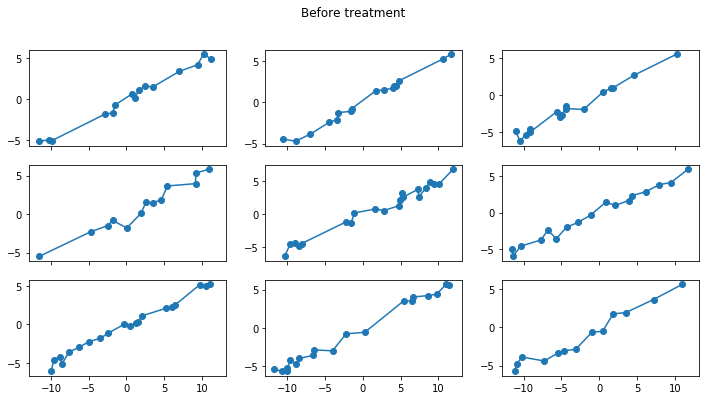

In [6]:
fig, axes = plt.subplots(3, 3, sharex=True, figsize=(12,6))
for i in range(3):
    for j in range(3):
        idx = i*3+j
        axes[i, j].plot(samples[idx][1], samples[idx][0], marker = 'o')
        
fig.suptitle('Before treatment')
plt.show()

In [7]:
policy1 = simulation.TreatmentPolicy(*policy1_params, rx_win, rx_effect)
policy2 = simulation.TreatmentPolicy(*policy2_params, rx_win, rx_effect)
policy3 = simulation.TreatmentPolicy(*policy3_params, rx_win, rx_effect)
policy4 = simulation.TreatmentPolicy(*policy4_params, rx_win, 0.0)  # Policy 1 with no effect.

In [8]:
train1 = simulation.treat_data_set(samples[:n_train], policy1, rng)
train2 = simulation.treat_data_set(samples[:n_train], policy2, rng)

In [9]:
def draw_samples(samples, nrow=3, ncol=3, title='', truncated_time=None):
    fig, axes = plt.subplots(nrow, ncol, sharex=True, figsize=(12,6))
    for i in range(nrow):
        for j in range(ncol):
            idx = i*nrow+j
            axes[i, j].plot(samples[idx][1][0], samples[idx][0], marker = 'o', color = 'b')
            for t, rx in zip(samples[idx][1][0], samples[idx][1][1]):
                if rx == 1:
                    axes[i, j].axvline(x=t, color = 'y')
            if truncated_time is not None:
                axes[i, j].axvline(x=truncated_time, color = 'r')
    fig.suptitle(title)
    plt.show()

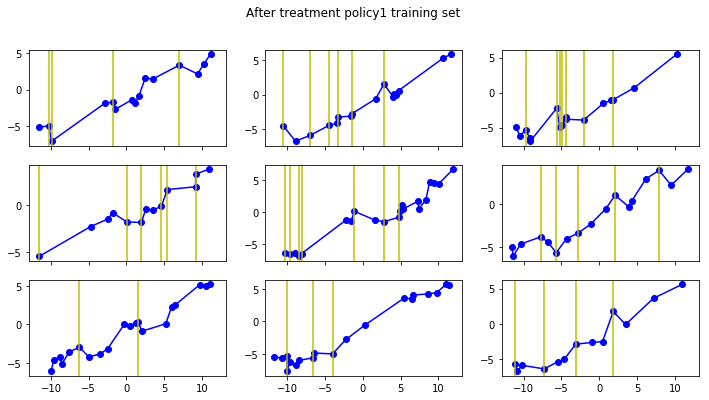

In [10]:
draw_samples(train1, 3, 3, 'After treatment policy1 training set')

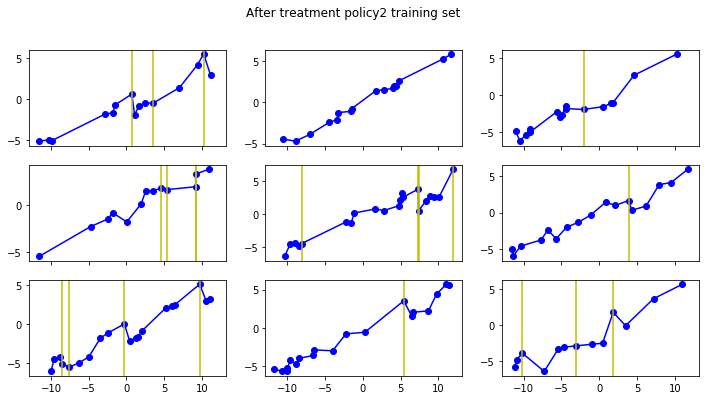

In [11]:
draw_samples(train2, 3, 3, 'After treatment policy2 training set')

In [12]:
test1 = simulation.truncate_treat_data_set(samples[n_train:], time, policy1, rng)
test2 = simulation.truncate_treat_data_set(samples[n_train:], time, policy2, rng)

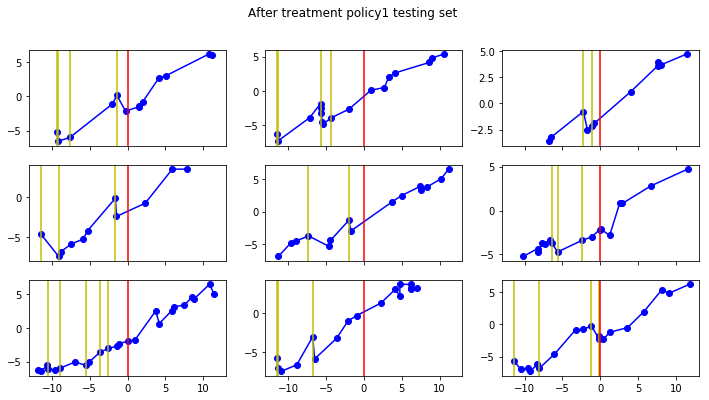

In [13]:
draw_samples(test1, 3, 3, 'After treatment policy1 testing set', truncated_time=time)

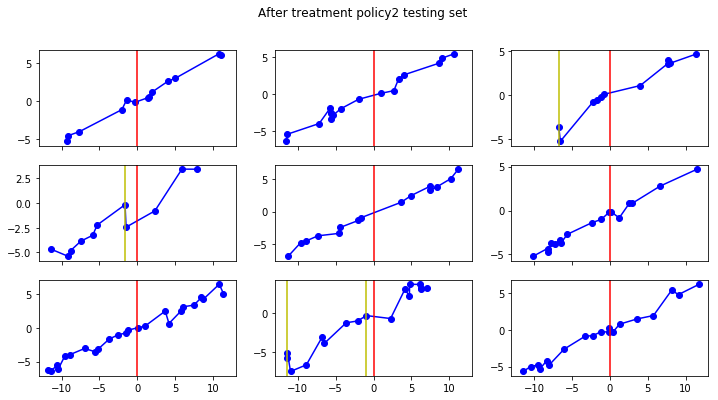

In [14]:
draw_samples(test2, 3, 3, 'After treatment policy2 testing set', truncated_time=time)

In [15]:
data_set = {
    'n_train'      : n_train,
    'truncated_time': time,
    'trajectories' : linear_func,
    'training1'     : train1,
    'testing1'      : test1,
    'training2'     : train2,
    'testing2'      : test2,
}

output_dir = 'dataset'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(os.path.join(output_dir, 'data_set_linear.pkl'), 'wb') as f:
    pickle.dump(data_set, f)